In [ ]:
# Propensity score matching
# 03.02.20/ Updated 03.20.20 / Updated 04.28.20

# We will use the datasets took second course (df_chem2, df_phys2) and ap takers (df_chemtakers, df_phystakers)
# The codes should be similar across chem, physics, and bio | feel free to update the codes

# We are using inverse probability weight (IPW). The idea is to assign greater weights for those less likely to receive treatment (i.e., AP real skip)
# This is because in the presence of confounding, estimate for the average treated and control outcomes may be biased
# (1) Calculate the propensity to be in the treatment (e.g., skip AP) from a set of covariates. We can use logistic regression.
# (2) Individuals with a lower propensity score (e.g., to skip AP) will receive larger weight
# More details about propensity score matching methods can be found here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/
# A demonstration of WeightIt for IPW: https://cran.r-project.org/web/packages/WeightIt/vignettes/WeightIt_A0_basic_use.html


In [1]:
# Load libraries
install.packages("pacman")
pacman::p_load("WeightIt", "cobalt", "survey", "jtools", "misaem")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# Load data
df_chem2 <- read.csv("/Users/thicn/Documents/AP Skip/chemap_unique2.csv")
df_phys2 <- read.csv("/Users/thicn/Documents/AP Skip/physap_unique2.csv")

In [2]:
df_chem2 <- read.csv("/Users/thicn/Documents/AP Skip/AP Skip_DataFrames_0425/df_chem2.csv")
df_phys2 <- read.csv("/Users/thicn/Documents/AP Skip/AP Skip_DataFrames_0425/df_phys2.csv")
df_chemtakers <- read.csv("/Users/thicn/Documents/AP Skip/AP Skip_DataFrames_0425/df_chemtakers.csv")
df_phystakers <- read.csv("/Users/thicn/Documents/AP Skip/AP Skip_DataFrames_0425/df_phystakers.csv")

In [3]:
names(df_chem2)

[1] "X"                "st_id"            "studentid"        "eligible_to_skip"
 [5] "tookap"           "apyear"           "apscore"          "coursecode"      
 [9] "crs_name"         "crs_catalog"      "class_number"     "crs_sbj"         
[13] "level"            "newfresh"         "gender"           "ethniccode"      
[17] "ethniccode_cat"   "ethniccode_cat2"  "firstgen"         "lowincomeflag"   
[21] "ellflag"          "hsgpa"            "hsgpa_z"          "bstsat1mathsr"   
[25] "bstsat1readsr"    "actenglsr"        "actmathsr"        "mathsr"          
[29] "englsr"           "crs_term"         "admitdate"        "enrl_from_cohort"
[33] "yearsenrolled"    "cohort"           "stemmajor"        "notSkip_Eli"     
[37] "skipped_course"   "numgrade"         "numgrade_2"       "discipline"      
[41] "numgrade_3"

In [4]:
# Start with CHEMISTRY
# First, estimate weights using Average Treatment on the Treated (ATT) from a
# logistic regression model to predict aprealskipper_GChem1
# A caveat for the weighit command is it only works iwth complete data
df_chem2_nomiss <- df_chem2[complete.cases(df_chem2$numgrade_2),]
head(df_chem2_nomiss)
# Make sure the predictor factor is coded in factor
df_chem2_nomiss$skipped_course <- as.factor(df_chem2_nomiss$skipped_course)
class(df_chem2_nomiss$skipped_course)
table(df_chem2_nomiss$skipped_course)

X,st_id,studentid,eligible_to_skip,tookap,apyear,apscore,coursecode,crs_name,crs_catalog,...,enrl_from_cohort,yearsenrolled,cohort,stemmajor,notSkip_Eli,skipped_course,numgrade,numgrade_2,discipline,numgrade_3
2,25,10006293,0,0,0,0,40240,GENERAL CHEMISTRY,4024020153CHEM,...,2,0.5,2014,2,0,0,2,2.3,CHEM,NA
6,51,10031543,0,0,0,0,40200,GENERAL CHEMISTRY,4020020173CHEM,...,2,0.5,2016,2,0,0,2,3.3,CHEM,NA
7,60,10041236,0,0,0,0,40220,GENERAL CHEMISTRY,4022020133CHEM,...,2,0.5,2013,2,0,0,NA,1.7,CHEM,NA
8,64,10046297,0,0,0,0,40240,GENERAL CHEMISTRY,4024020133CHEM,...,2,0.5,2013,1,0,0,NA,2.0,CHEM,NA
10,83,10062453,0,0,0,0,40200,GENERAL CHEMISTRY,4020020173CHEM,...,2,0.5,2016,2,0,0,4,3.7,CHEM,NA
11,107,10077745,0,0,0,0,40240,GENERAL CHEMISTRY,4024020133CHEM,...,2,0.5,2013,2,0,0,NA,2.0,CHEM,NA


[1] "factor"


   0    1 
8132  134 

In [5]:
# Are our covariates imbalanced?
bal.tab(skipped_course ~ factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + scale(englsr) + factor(cohort),
        data = df_chem2_nomiss, estimand = "ATT", m.threshold = .05)

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Balance Measures
                            Type Diff.Un      M.Threshold.Un
factor(firstgen)_1        Binary -0.3091 Not Balanced, >0.05
factor(firstgen):<NA>     Binary  0.0048     Balanced, <0.05
factor(lowincomeflag)_2   Binary -0.1245 Not Balanced, >0.05
factor(gender)_1          Binary -0.2176 Not Balanced, >0.05
factor(gender):<NA>       Binary  0.0052     Balanced, <0.05
factor(ethniccode_cat)_0  Binary -0.0163     Balanced, <0.05
factor(ethniccode_cat)_1  Binary -0.2487 Not Balanced, >0.05
factor(ethniccode_cat)_2  Binary  0.2650 Not Balanced, >0.05
hsgpa_z                  Contin.  0.6538 Not Balanced, >0.05
scale(mathsr)            Contin.  1.9723 Not Balanced, >0.05
scale(englsr)            Contin.  1.0823 Not Balanced, >0.05
factor(cohort)_2013       Binary -0.3887 Not Balanced, >0.05
factor(cohort)_2014       Binary -0.0190     Balanced, <0.05
factor(cohort)_2015       Binary  0.0851 Not Balanced, >0.05
factor(cohort)_2016       Binary  0.3232 Not Balanced, >0.05
factor(

In [6]:
# Estimate weight; because we still have missing data, use stochastic approximation of the EM algorithm (SAEM) through the misaem package
# More details on SAEM: http://juliejosse.com/wp-content/uploads/2018/07/LectureNotesMissing.html
# Estimate = Average treatment for the treated
# method = propensity score to calculate weights
skip_weight <- weightit(skipped_course~factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + scale(englsr) + factor(cohort), 
                      data=df_chem2_nomiss, estimand="ATT", method="ps", missing = "saem")
skip_weight

A weightit object
 - method: "ps" (propensity score weighting)
 - number of obs.: 8266
 - sampling weights: none
 - treatment: 2-category
 - estimand: ATT (focal: 1)
 - covariates: factor(firstgen), factor(lowincomeflag), factor(gender), factor(ethniccode_cat), hsgpa_z, scale(mathsr), scale(englsr), factor(cohort)

In [7]:
summary(skip_weight)

                 Summary of weights

- Weight ranges:

        Min                                  Max
treated   1                     ||        1.0000
control   0 |---------------------------| 1.4388

- Units with 5 greatest weights by group:
                                          
             87    129    161   164    316
 treated      1      1      1     1      1
           7916   6079   5988  3900     83
 control 0.7143 0.7525 0.8007 0.924 1.4388

- Weight statistics:

        Coef of Var   MAD    Entropy
treated       0.000 0.000      0.000
control       3.270 1.409 -19189.195
overall       4.165 1.531  -9770.554

- Effective Sample Sizes:

            Control Treated
Unweighted 8132.000     134
Weighted    695.393     134

In [8]:
# Is our weight more balanced?
bal.tab(skip_weight, m.threshold = .05, disp.v.ratio=T) #much more balanced

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Call
 weightit(formula = skipped_course ~ factor(firstgen) + factor(lowincomeflag) + 
    factor(gender) + factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + 
    scale(englsr) + factor(cohort), data = df_chem2_nomiss, method = "ps", 
    estimand = "ATT", missing = "saem")

Balance Measures
                             Type Diff.Adj     M.Threshold V.Ratio.Adj
prop.score               Distance  -0.0261                      1.0299
factor(firstgen)_1         Binary  -0.0044 Balanced, <0.05            
factor(firstgen):<NA>      Binary   0.0041 Balanced, <0.05            
factor(lowincomeflag)_2    Binary  -0.0129 Balanced, <0.05            
factor(gender)_1           Binary   0.0068 Balanced, <0.05            
factor(gender):<NA>        Binary   0.0054 Balanced, <0.05            
factor(ethniccode_cat)_0   Binary  -0.0057 Balanced, <0.05            
factor(ethniccode_cat)_1   Binary   0.0002 Balanced, <0.05            
factor(ethniccode_cat)_2   Binary   0.0055 Balanced, <0.05          

In [11]:
# With weights estimated, estimate the treatment effect, using "survey" package
# Regression to predict grades in CHEM1B. 2c: Full sample, include AP score
chem.w <- svydesign(ids=~1, weights=get.w(skip_weight), data=df_chem2_nomiss)
fitchem_2c <- svyglm(numgrade_2~factor(skipped_course)+apscore +
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chem.w)
coef(fitchem_2c)
#std_beta(fitchem_2c) # "sjstats" package; can't get it to load in jupyter notebook

(Intercept) factor(skipped_course)1                 apscore 
             2.66965116              0.07059492              0.09843816 
      factor(firstgen)1  factor(lowincomeflag)2         factor(gender)1 
            -0.01468263             -0.07564876             -0.13530352 
factor(ethniccode_cat)1 factor(ethniccode_cat)2                 hsgpa_z 
            -0.16058273             -0.17390105              0.27258599 
          scale(mathsr)           scale(englsr)    factor(crs_term)2014 
             0.26643929              0.01995174             -0.61476687 
   factor(crs_term)2015    factor(crs_term)2016    factor(crs_term)2017 
            -0.01135819              0.09848421              0.06089621

MODEL INFO:
Observations: 8101
Dependent Variable: numgrade_2
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.20
Adj. R² = 0.20 

Standard errors: Robust
------------------------------------------------------------------------------
                                 Est.    2.5%   97.5%   t val.      p      VIF
----------------------------- ------- ------- ------- -------- ------ --------
(Intercept)                      2.67    2.40    2.94    19.25   0.00         
factor(skipped_course)1          0.07   -0.13    0.27     0.68   0.50     5.75
apscore                          0.10    0.06    0.14     4.80   0.00     6.31
factor(firstgen)1               -0.01   -0.25    0.22    -0.12   0.90     4.42
factor(lowincomeflag)2          -0.08   -0.23    0.07    -0.99   0.32     8.98
factor(gender)1                 -0.14   -0.28    0.01    -1.88   0.06     6.82
factor(ethniccode_cat)1         -0.16   -0.40    0.08    -1.29   0.20     3.38
factor(ethniccode_cat)2         -0.17   -0.3

Registered S3 methods overwritten by 'broom':
  method            from  
  tidy.glht         jtools
  tidy.summary.glht jtools



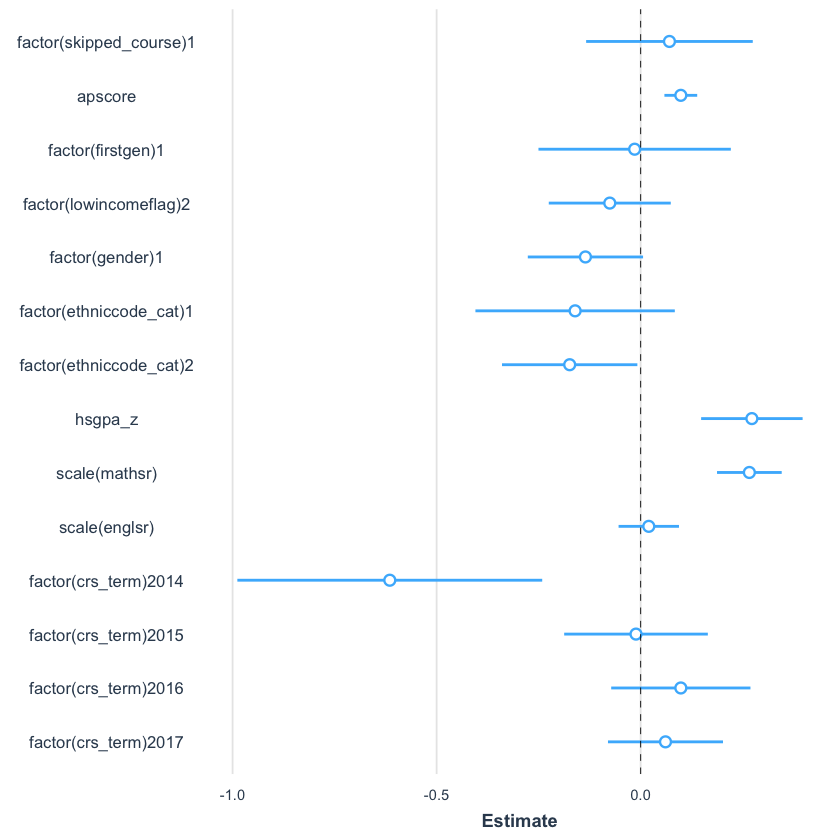

In [12]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2c <- summ(fitchem_2c, confint=T, vifs=T)
chem2c
plot_summs(chem2c, scale=T) #Get coeff. plot with CI, scale=T for easy assessment across var

In [13]:
# 2e. 2nd course grade; everyone, actually skipped
# The weight is the same as 2c (predicting propensity to skip from full dataset)
# Regression to predict grades in CHEM1B: NOT include AP score
#chem.w <- svydesign(ids=~1, weights=get.w(skip_weight), data=chemap_unique_nomiss)
fitchem_2e <- svyglm(numgrade_2~factor(skipped_course)+
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chem.w)
coef(fitchem_2e)


(Intercept) factor(skipped_course)1       factor(firstgen)1 
             2.62231047              0.40392170             -0.01974734 
 factor(lowincomeflag)2         factor(gender)1 factor(ethniccode_cat)1 
            -0.06228170             -0.13477512             -0.15769268 
factor(ethniccode_cat)2                 hsgpa_z           scale(mathsr) 
            -0.15376283              0.27703415              0.28557013 
          scale(englsr)    factor(crs_term)2014    factor(crs_term)2015 
             0.02180698             -0.55164895              0.03680483 
   factor(crs_term)2016    factor(crs_term)2017 
             0.17627295              0.14267385

MODEL INFO:
Observations: 8101
Dependent Variable: numgrade_2
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.19
Adj. R² = 0.19 

Standard errors: Robust
------------------------------------------------------------------------------
                                 Est.    2.5%   97.5%   t val.      p      VIF
----------------------------- ------- ------- ------- -------- ------ --------
(Intercept)                      2.62    2.35    2.89    19.21   0.00         
factor(skipped_course)1          0.40    0.27    0.54     5.87   0.00     2.51
factor(firstgen)1               -0.02   -0.26    0.22    -0.16   0.87     4.49
factor(lowincomeflag)2          -0.06   -0.21    0.09    -0.81   0.42     9.00
factor(gender)1                 -0.13   -0.28    0.01    -1.85   0.06     6.65
factor(ethniccode_cat)1         -0.16   -0.40    0.09    -1.25   0.21     3.43
factor(ethniccode_cat)2         -0.15   -0.32    0.01    -1.84   0.07     3.43
hsgpa_z                          0.28    0.1

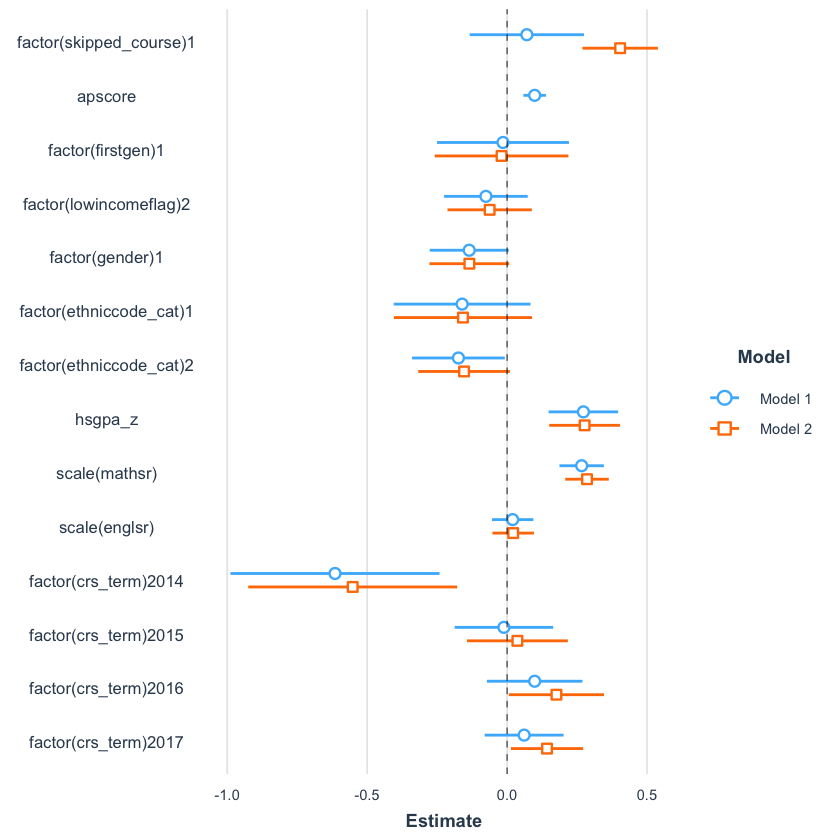

In [14]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2e <- summ(fitchem_2e, confint=T, vifs=T)
chem2e
plot_summs(chem2c, chem2e, scale=T)

In [15]:
# 2g. Skip eligible, full sample
# First, check if covariates are balanced
bal.tab(eligible_to_skip ~ factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + scale(englsr) + factor(cohort),
        data = df_chem2_nomiss, estimand = "ATT", m.threshold = .05) # not really balanced

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Balance Measures
                            Type Diff.Un      M.Threshold.Un
factor(firstgen)_1        Binary -0.2702 Not Balanced, >0.05
factor(firstgen):<NA>     Binary  0.0009     Balanced, <0.05
factor(lowincomeflag)_2   Binary -0.1172 Not Balanced, >0.05
factor(gender)_1          Binary -0.1867 Not Balanced, >0.05
factor(gender):<NA>       Binary  0.0040     Balanced, <0.05
factor(ethniccode_cat)_0  Binary -0.0086     Balanced, <0.05
factor(ethniccode_cat)_1  Binary -0.2451 Not Balanced, >0.05
factor(ethniccode_cat)_2  Binary  0.2537 Not Balanced, >0.05
hsgpa_z                  Contin.  0.7276 Not Balanced, >0.05
scale(mathsr)            Contin.  1.7093 Not Balanced, >0.05
scale(englsr)            Contin.  1.0545 Not Balanced, >0.05
factor(cohort)_2013       Binary -0.3901 Not Balanced, >0.05
factor(cohort)_2014       Binary -0.0493     Balanced, <0.05
factor(cohort)_2015       Binary  0.2103 Not Balanced, >0.05
factor(cohort)_2016       Binary  0.2296 Not Balanced, >0.05
factor(

In [16]:
# Next, calculate weights
skipEl_weight <- weightit(eligible_to_skip~factor(firstgen) + factor(lowincomeflag) + factor(gender) + 
        factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + scale(englsr) + factor(cohort), 
                      data=df_chem2_nomiss, estimand="ATT", method="ps", missing = "saem")
summary(skipEl_weight)

                 Summary of weights

- Weight ranges:

        Min                                  Max
treated   1                         ||    1.0000
control   0 |---------------------------| 1.1904

- Units with 5 greatest weights by group:
                                           
             64    116    129    134    164
 treated      1      1      1      1      1
           7978   7916   6079   3900   2970
 control 0.8061 0.9468 1.1136 1.1221 1.1904

- Weight statistics:

        Coef of Var   MAD    Entropy
treated       0.000 0.000      0.000
control       2.996 1.377 -18469.849
overall       3.781 1.502  -9421.737

- Effective Sample Sizes:

            Control Treated
Unweighted 8104.000     162
Weighted    812.298     162

In [17]:
# Is our weight more balanced? Yep
bal.tab(skipEl_weight, m.threshold = .05, disp.v.ratio=T)

Warning message:
“Missing values exist in the covariates. Displayed values omit these observations.”


Call
 weightit(formula = eligible_to_skip ~ factor(firstgen) + factor(lowincomeflag) + 
    factor(gender) + factor(ethniccode_cat) + hsgpa_z + scale(mathsr) + 
    scale(englsr) + factor(cohort), data = df_chem2_nomiss, method = "ps", 
    estimand = "ATT", missing = "saem")

Balance Measures
                             Type Diff.Adj     M.Threshold V.Ratio.Adj
prop.score               Distance  -0.0032                      1.0835
factor(firstgen)_1         Binary  -0.0103 Balanced, <0.05            
factor(firstgen):<NA>      Binary  -0.0002 Balanced, <0.05            
factor(lowincomeflag)_2    Binary  -0.0129 Balanced, <0.05            
factor(gender)_1           Binary   0.0075 Balanced, <0.05            
factor(gender):<NA>        Binary   0.0043 Balanced, <0.05            
factor(ethniccode_cat)_0   Binary  -0.0082 Balanced, <0.05            
factor(ethniccode_cat)_1   Binary  -0.0008 Balanced, <0.05            
factor(ethniccode_cat)_2   Binary   0.0089 Balanced, <0.05        

In [18]:
# Calculate models given weights
chemEl.w <- svydesign(ids=~1, weights=get.w(skipEl_weight), data=df_chem2_nomiss)
fitchem_2g <- svyglm(numgrade_2~factor(eligible_to_skip)+
                     factor(firstgen) + factor(lowincomeflag) + factor(gender)+ factor(ethniccode_cat) + 
                     hsgpa_z + scale(mathsr) + scale(englsr) + factor(crs_term), design=chemEl.w)
coef(fitchem_2g)

(Intercept) factor(eligible_to_skip)1         factor(firstgen)1 
               2.56737281                0.37912233               -0.02453471 
   factor(lowincomeflag)2           factor(gender)1   factor(ethniccode_cat)1 
              -0.06412216               -0.11421240               -0.13496602 
  factor(ethniccode_cat)2                   hsgpa_z             scale(mathsr) 
              -0.12543570                0.28602694                0.32205171 
            scale(englsr)      factor(crs_term)2014      factor(crs_term)2015 
               0.00361280               -0.49869551                0.04284896 
     factor(crs_term)2016      factor(crs_term)2017 
               0.10275638                0.13897618

MODEL INFO:
Observations: 8101
Dependent Variable: numgrade_2
Type: Survey-weighted linear regression 

MODEL FIT:
R² = 0.20
Adj. R² = 0.20 

Standard errors: Robust
--------------------------------------------------------------------------------
                                   Est.    2.5%   97.5%   t val.      p      VIF
------------------------------- ------- ------- ------- -------- ------ --------
(Intercept)                        2.57    2.33    2.81    20.96   0.00         
factor(eligible_to_skip)1          0.38    0.26    0.50     6.13   0.00     2.15
factor(firstgen)1                 -0.02   -0.21    0.17    -0.25   0.80     3.74
factor(lowincomeflag)2            -0.06   -0.20    0.07    -0.91   0.36     8.32
factor(gender)1                   -0.11   -0.25    0.02    -1.67   0.10     6.27
factor(ethniccode_cat)1           -0.13   -0.36    0.09    -1.19   0.23     2.93
factor(ethniccode_cat)2           -0.13   -0.29    0.04    -1.53   0.13     2.93
hsgpa_z                 

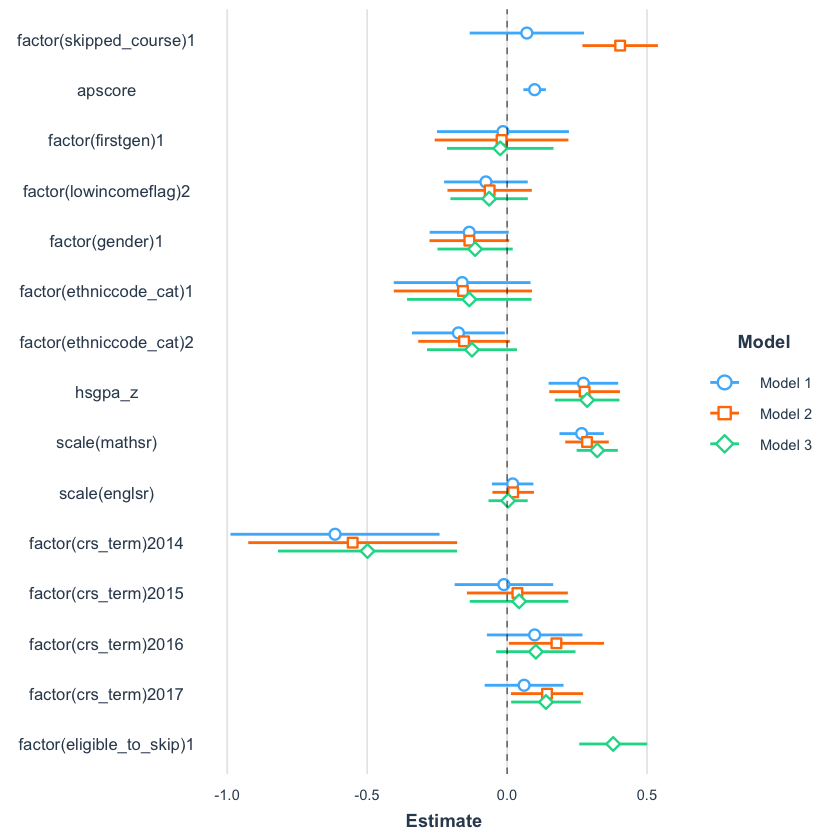

In [19]:
#Obtain robust SE, CI, and VIF with "jtools"
chem2g <- summ(fitchem_2g, confint=T, vifs=T)
chem2g
plot_summs(chem2c, chem2e, chem2g, scale=T) # estimates for covariates are pretty close

In [ ]:
# For 2b, 2d, 2f with the AP take sample but use df_chemtakers dataset
# Same analyses: calculate weights with weightit; 
# check for balance using bal.tab, 
# use the weights towards the models, and estimate robust SE/coefficients